In [ ]:
# # Для работы в колабе раскоменьте эти строки
!git clone https://github.com/HSE-LAMBDA/DeepGenerativeModels.git
%cd DeepGenerativeModels/

/home/jupyter/work/resources/DeepGenerativeModels


In [ ]:
! git clone https://github.com/S-aiueo32/lpips-pytorch.git
%pip install git+https://github.com/S-aiueo32/lpips-pytorch.git
%pip install munch

In [ ]:
import shutil
import os
! mkdir data
! mkdir data/celeba

# Загрузка данных


In [ ]:
import os
import zipfile 
import gdown
import torch
from natsort import natsorted
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
import re
import numpy as np
import torch


## Create a custom Dataset class
class CelebADataset(Dataset):
    def __init__(self, root_dir='data/celeba', transform=None):
        """
        Args:
          root_dir (string): Directory with all the images
          transform (callable, optional): transform to be applied to each image sample
        """
        dataset_folder = f'{root_dir}/img_align_celeba/'
        self.dataset_folder = os.path.abspath(dataset_folder)
        if not os.path.isdir(dataset_folder):
            # URL for the CelebA dataset
            download_url = 'https://drive.google.com/uc?id=0B7EVK8r0v71pZjFTYXZWM3FlRnM'
            # Path to download the dataset to
            download_path = f'{root_dir}/img_align_celeba.zip'
            
            with zipfile.ZipFile(download_path, 'r') as ziphandler:
                ziphandler.extractall(root_dir)

        image_names = os.listdir(self.dataset_folder)

        self.transform = transform 
        image_names = natsorted(image_names)
        
        self.filenames = []
        self.annotations = []
        with open(f'{root_dir}/list_attr_celeba.txt') as f:
            for i, line in enumerate(f.readlines()):
                line = re.sub(' *\n', '', line)
                if i == 0:
                    self.header = re.split(' +', line)
                else:
                    values = re.split(' +', line)
                    filename = values[0]
                    self.filenames.append(filename)
                    self.annotations.append(int(values[23].replace('-1', '0'), base=2))
                
        self.annotations = np.array(self.annotations)    

    def __len__(self): 
        return len(self.filenames)

    def __getitem__(self, idx):
        # Get the path to the image 
        img_name = self.filenames[idx]
        img_path = os.path.join(self.dataset_folder, img_name)
        img_attributes = self.annotations[idx] # binary Mustache
        # Load image and convert it to RGB
        img = Image.open(img_path).convert('RGB')
        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)
        return img, {'filename': img_name, 'idx': idx, 'attributes': torch.tensor(img_attributes).long()}


In [ ]:
import sys; sys.path.append('/DeepGenerativeModels/utils')
import torch
import torch.nn.functional as F
from lpips_pytorch import LPIPS
from torchvision import transforms
from munch import Munch
import gc
from tqdm.auto import trange

## Setup
# Number of gpus available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = Munch()

args.num_domains = 2 # Задайте число доменов

# Spatial size of training images, images are resized to this size.
args.img_size = 64
args.batch_size = 16

# Transformations to be applied to each individual image sample
transform=transforms.Compose([
    transforms.Resize(args.img_size),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])
# Load the dataset from file and apply transformations
dataset = CelebADataset(transform=transform)

# Number of workers for the dataloader
num_workers = 0 if device.type == 'cuda' else 2
# Whether to put fetched data tensors to pinned memory
pin_memory = True if device.type == 'cuda' else False


# dataloader for batched data loading
dataloader = torch.utils.data.DataLoader(dataset,
                                                batch_size=args.batch_size,
                                                num_workers=num_workers,
                                                pin_memory=pin_memory,
                                                shuffle=True)

## Визуализация датасетов

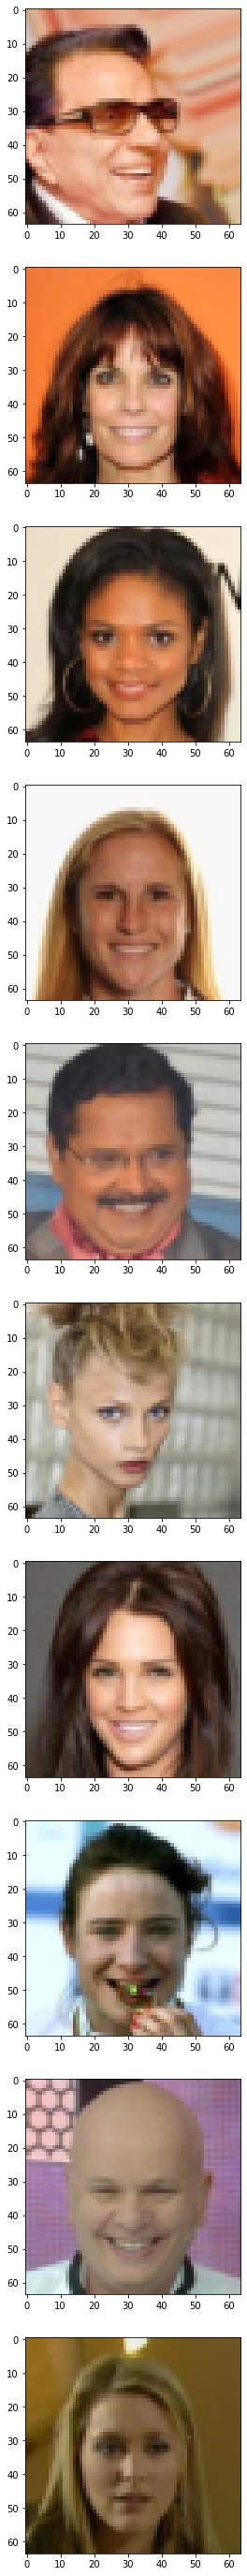

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images_cnt = 10
plt.figure(figsize=(17,images_cnt*5))
for i, img_idx in enumerate(np.random.choice(range(len(dataset)), images_cnt)):
    img, target = dataset[img_idx]
    # attributes dict for a given image. Contains 40 attributes
    plt.subplot(images_cnt,1,i+1)
    plt.imshow((img.detach().cpu().numpy().transpose(1,2,0) + 1)/2)

#Обучение модели


In [ ]:
import copy

import numpy as np
import torch
import torch.nn as nn

class AdaIN(nn.Module):
    def __init__(self, style_dim, num_features):
        super().__init__()
        self.norm = nn.InstanceNorm2d(num_features, affine=False)
        self.fc = nn.Linear(style_dim, num_features*2)

    def forward(self, x, s):
        h = self.fc(s)
        h = h.view(h.size(0), h.size(1), 1, 1)
        gamma, beta = torch.chunk(h, chunks=2, dim=1)
        return (1 + gamma) * self.norm(x) + beta

class ResBlk(nn.Module):
    
    def __init__(self, in_channels, out_channels, type=None, norm=None, style_dim=None):
        super().__init__()

        self.change_size = nn.AvgPool2d(2) if type == 'down' else nn.Upsample(scale_factor=2) if type == 'up' else nn.Identity()

        self.norm1 = nn.InstanceNorm2d(in_channels) if norm=='IN' else AdaIN(style_dim, in_channels) if norm=='AdaIN' else nn.Identity()
        self.act_conv1 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(in_channels, in_channels, 3, padding='same'))
        self.norm2 = nn.InstanceNorm2d(out_channels) if norm=='IN' else AdaIN(style_dim, in_channels) if norm=='AdaIN' else nn.Identity()
        self.act_conv2 = nn.Sequential(nn.LeakyReLU(), nn.Conv2d(in_channels, out_channels, 3, padding='same'))
        
        self.conv1x1 = nn.Conv2d(in_channels, out_channels, 1) # для изменения числа каналов исходного изображения
        

    def forward(self, x, s=None):
        if s is None:
            return self.conv1x1(self.change_size(x)) + self.act_conv2(self.norm2(self.change_size(self.act_conv1(self.norm1(x)))))
        return self.conv1x1(self.change_size(x)) + self.act_conv2(self.norm2(self.change_size(self.act_conv1(self.norm1(x, s))), s))
        
class Generator(nn.Module):
    def __init__(self, style_dim=32):
        super().__init__()
        
        self.first_conv = nn.Conv2d(3, 32, 1)
        # уменьшаем число блоков в два раза, уменьшаем макс число каналов с 512 до 128
        self.down = nn.Sequential(ResBlk(32, 64, type='down', norm='IN'), 
                                  ResBlk(64, 128, type='down', norm='IN'))
        self.middle1 = ResBlk(128, 128, norm='IN') 
        self.middle2 = ResBlk(128, 128, norm='AdaIN', style_dim=style_dim)
                                    
        self.up1 = ResBlk(128, 64, type='up', norm='AdaIN', style_dim=style_dim) 
        self.up2 = ResBlk(64, 32, type='up', norm='AdaIN', style_dim=style_dim)

        self.last_conv = nn.Conv2d(32, 3, 1) 

    def forward(self, x, s): 
        x = self.down(self.first_conv(x))
        x = self.middle1(x)
        x = self.middle2(x, s)
        x = self.up1(x, s)
        x = self.up2(x, s)
        return self.last_conv(x)


class MappingNetwork(nn.Module):
    def __init__(self, latent_dim=16, style_dim=32, num_domains=2):
        super().__init__()
        # число каналов везде уменьшилось с 512 до 256
        self.shared = nn.Sequential(nn.Linear(latent_dim, 256),
                               nn.ReLU(),
                               nn.Linear(256, 256),
                               nn.ReLU(),
                               nn.Linear(256, 256),
                               nn.ReLU(),
                               nn.Linear(256, 256),
                               nn.ReLU())

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Sequential(nn.Linear(256, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, 256),
                                            nn.ReLU(),
                                            nn.Linear(256, style_dim))]

    def forward(self, z, y):
        h = self.shared(z)
        out = torch.stack([layer(h) for layer in self.unshared], dim=1)
        s = out[torch.LongTensor(range(y.size(0))).to(y.device), y.to(torch.long)] 
        return s


class StyleEncoder(nn.Module):
    def __init__(self, style_dim=32, num_domains=2):
        super().__init__()
        # сократилось число res блоков с 6 до 4, макс число каналов 512 -> 128
        self.net = nn.Sequential(nn.Conv2d(3, 32, 1),
                                  ResBlk(32, 64, type='down'),
                                  ResBlk(64, 128, type='down'),
                                  ResBlk(128, 128, type='down'),
                                  ResBlk(128, 128, type='down'),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(128, 128, 4, 1, 0),
                                  nn.LeakyReLU(),
                                  nn.Flatten())

        self.unshared = nn.ModuleList()
        for _ in range(num_domains):
            self.unshared += [nn.Linear(128, style_dim)]

    def forward(self, x, y):
        h = self.net(x)
        out = torch.stack([layer(h) for layer in self.unshared], dim=1)
        s = out[torch.LongTensor(range(y.size(0))).to(y.device), y.to(torch.long)]
        return s


class Discriminator(nn.Module):
    def __init__(self, num_domains=2):
        super().__init__()
        # сократилось число res блоков с 6 до 4, макс число каналов 512 -> 128
        self.net = nn.Sequential(nn.Conv2d(3, 32, 1),
                                  ResBlk(32, 64, type='down'), 
                                  ResBlk(64, 128, type='down'),
                                  ResBlk(128, 128, type='down'),
                                  ResBlk(128, 128, type='down'),
                                  nn.LeakyReLU(),
                                  nn.Conv2d(128, 128, 4, 1, 0),
                                  nn.LeakyReLU(),
                                  nn.Flatten(),
                                  nn.Linear(128, num_domains))

    def forward(self, x, y):
        out = self.net(x)
        out = out[torch.LongTensor(range(y.size(0))).to(y.device), y.to(torch.long)]
        return out
    
def he_init(module):
    if isinstance(module, nn.Conv2d):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    if isinstance(module, nn.Linear):
        nn.init.kaiming_normal_(module.weight, mode='fan_in', nonlinearity='relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)

In [ ]:
# добавляем все модели
nets = Munch()
nets.generator = Generator().apply(he_init)
nets.mapping_network = MappingNetwork().apply(he_init)
nets.style_encoder = StyleEncoder().apply(he_init)
nets.discriminator = Discriminator().apply(he_init)


# при тестировании используем скользящее среднее всего кроме дискриминатора
nets_ema = Munch()
nets_ema.generator = copy.deepcopy(nets.generator)
nets_ema.mapping_network = copy.deepcopy(nets.mapping_network)
nets_ema.style_encoder = copy.deepcopy(nets.style_encoder)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

for net in nets.keys():
    nets[net] = nets[net].to(device)
for net in nets_ema.keys():
    nets_ema[net] = nets_ema[net].to(device)

# оптимайзеры
optims = Munch()
optims.generator = torch.optim.Adam(nets.generator.parameters(), lr=1e-4, betas=(0, 0.99))
optims.mapping_network = torch.optim.Adam(nets.mapping_network.parameters(), lr=1e-5, betas=(0, 0.99))
optims.style_encoder = torch.optim.Adam(nets.style_encoder.parameters(), lr=1e-4, betas=(0, 0.99))
optims.discriminator = torch.optim.Adam(nets.discriminator.parameters(), lr=1e-4, betas=(0, 0.99))

# константы для лосса
args.lambda_ds = 1
#еще для обучения
args.latent_dim = 16
args.n_epochs = 4

In [ ]:
print('число параметров в generator =', sum(p.numel() for p in nets.generator.parameters()))
print('число параметров в mapping_network =', sum(p.numel() for p in nets.mapping_network.parameters()))
print('число параметров в style_encoder =', sum(p.numel() for p in nets.style_encoder.parameters()))
print('число параметров в discriminator =', sum(p.numel() for p in nets.discriminator.parameters()))

число параметров в generator = 1101891
число параметров в mapping_network = 481344
число параметров в style_encoder = 1042976
число параметров в discriminator = 1034978


In [ ]:
from datetime import datetime

import numpy as np
import pandas as pd
import wandb
import os

# логирование
class WanDBWriter:
    def __init__(self, wandb_project, wandb_api_key):
        self.writer = None
        self.selected_module = ""

        os.environ["WANDB_API_KEY"] = wandb_api_key
        wandb.login()

        wandb.init(project=wandb_project)
        self.wandb = wandb

        self.step = 0
        self.mode = ""
        self.timer = datetime.now()

    def set_step(self, step, mode=""):
        self.mode = mode
        self.step = step
        if step == 0:
            self.timer = datetime.now()
        else:
            duration = datetime.now() - self.timer
            self.add_scalar("steps_per_sec", 1 / duration.total_seconds())
            self.timer = datetime.now()

    def _scalar_name(self, scalar_name):
        return f"{scalar_name}_{self.mode}"

    def add_scalar(self, scalar_name, scalar):
        self.wandb.log({
            self._scalar_name(scalar_name): scalar,
        }, step=self.step)

    def add_scalars(self, tag, scalars):
        self.wandb.log({
            **{f"{scalar_name}_{tag}_{self.mode}": scalar for scalar_name, scalar in
               scalars.items()}
        }, step=self.step)

    def add_image(self, scalar_name, image):
        self.wandb.log({
            self._scalar_name(scalar_name): self.wandb.Image(image)
        }, step=self.step)

In [ ]:
from torchvision import transforms as T

def adv_loss(logits, target): # target = 1, если изображение настоящее и  0 иначе
    assert target in [1, 0]
    targets = torch.full_like(logits, fill_value=target)
    loss = F.binary_cross_entropy_with_logits(logits, targets)
    return loss

def l1_loss(x, y):
    return 

def r1_reg(d_out, x_in):
    grad_dout = torch.autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True)[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = 0.5 * grad_dout2.view(x_in.size(0), -1).sum(1).mean(0)
    return reg

def moving_average(model, model_test, beta=0.999):
    for param, param_test in zip(model.parameters(), model_test.parameters()):
        param_test.data = torch.lerp(param.data, param_test.data, beta)

def compute_d_loss(logger, log, nets, args, x_real, y_org, y_trg, z_trg=None, x_ref=None):
    assert (z_trg is None) != (x_ref is None)
    # with real images
    x_real.requires_grad_()
    out = nets.discriminator(x_real, y_org) 
    loss_real = adv_loss(out, 1)
    loss_reg = r1_reg(out, x_real)

    # with fake images
    with torch.no_grad():
        if z_trg is not None:
            s_trg = nets.mapping_network(z_trg, y_trg)
        else:
            s_trg = nets.style_encoder(x_ref, y_trg)

        x_fake = nets.generator(x_real, s_trg)
    out = nets.discriminator(x_fake, y_trg)
    loss_fake = adv_loss(out, 0)

    loss = loss_real + loss_fake + loss_reg
    if log:
        logger.add_scalar('discriminator loss_real', loss_real)
        logger.add_scalar('discriminator loss_fake', loss_fake)
        logger.add_scalar('discriminator loss_reg', loss_reg)
        logger.add_scalar('discriminator loss', loss)
    return loss, Munch(real=loss_real.item(),
                       fake=loss_fake.item(),
                       reg=loss_reg.item())


def compute_g_loss(logger, log, nets, args, x_real, y_org, y_trg, z_trgs=None, x_refs=None):
    assert (z_trgs is None) != (x_refs is None)
    if z_trgs is not None:
        z_trg, z_trg2 = z_trgs
    if x_refs is not None:
        x_ref, x_ref2 = x_refs

    # adversarial loss
    if z_trgs is not None:
        s_trg = nets.mapping_network(z_trg, y_trg)
    else:
        s_trg = nets.style_encoder(x_ref, y_trg)

    x_fake = nets.generator(x_real, s_trg)
    
    if log:
        image = (x_real[0] + 1) / 2
        logger.add_image('real image 1', image.detach().cpu())
        
        image = (x_fake[0] + 1) / 2
        logger.add_image('fake image 1', image.detach().cpu())
        
        image = (x_real[1] + 1) / 2
        logger.add_image('real image 2', image.detach().cpu())
        
        image = (x_fake[1] + 1) / 2
        logger.add_image('fake image 2', image.detach().cpu())
        
        

    out = nets.discriminator(x_fake, y_trg)
    loss_adv = adv_loss(out, 1)

    # style reconstruction loss
    s_pred = nets.style_encoder(x_fake, y_trg)
    loss_sty = torch.mean(torch.abs(s_pred - s_trg))

    # diversity sensitive loss
    if z_trgs is not None:
        s_trg2 = nets.mapping_network(z_trg2, y_trg)
    else:
        s_trg2 = nets.style_encoder(x_ref2, y_trg)
    x_fake2 = nets.generator(x_real, s_trg2).detach()
    loss_ds = torch.mean(torch.abs(x_fake - x_fake2))

    # cycle-consistency loss
    s_org = nets.style_encoder(x_real, y_org)
    x_rec = nets.generator(x_fake, s_org)
    loss_cyc = torch.mean(torch.abs(x_rec - x_real))

    loss = loss_adv + loss_sty - args.lambda_ds * loss_ds + loss_cyc
    if log:
        logger.add_scalar('generator loss_adv', loss_adv)
        logger.add_scalar('generator loss_sty', loss_sty)
        logger.add_scalar('generator loss_ds', loss_ds)
        logger.add_scalar('generator loss_cyc', loss_cyc)
        logger.add_scalar('generator loss', loss)
    return loss, Munch(adv=loss_adv.item(),
                       sty=loss_sty.item(),
                       ds=loss_ds.item(),
                       cyc=loss_cyc.item())

In [ ]:
import os
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch

logger = WanDBWriter('StarGAN v2', '...')

delta_lambda_ds = 1 / (args.n_epochs * len(dataloader))
current_step = 0
for i in range(args.n_epochs):
    for x_real, d in tqdm(dataloader):
        
        current_step += 1
        logger.set_step(current_step, '')
        x_real = x_real.to(device)
        y_org = d['attributes'].to(device)
        args.lambda_ds -= delta_lambda_ds
        
        x_ref, _ = next(iter(dataloader))
        x_ref2, _ = next(iter(dataloader))
        x_ref = x_ref.to(device)
        x_ref2 = x_ref2.to(device)
        y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=y_org.shape[0])).to(device)
            
        z_trg = torch.randn(x_ref.size(0), args.latent_dim).to(device)
        z_trg2 = torch.randn(x_ref.size(0), args.latent_dim).to(device)
        

        # train the discriminator
        d_loss, d_losses_latent = compute_d_loss(logger, (current_step % 50 == 0), nets, args, x_real, y_org, y_trg, z_trg=z_trg)
        for key in optims.keys():
            optims[key].zero_grad()
        d_loss.backward()
        optims.discriminator.step()

        d_loss, d_losses_ref = compute_d_loss(logger, (current_step % 50 == 0), nets, args, x_real, y_org, y_trg, x_ref=x_ref)
        for key in optims.keys():
            optims[key].zero_grad()
        d_loss.backward()
        optims.discriminator.step()

        # train the generator
        g_loss, g_losses_latent = compute_g_loss(logger, (current_step % 50 == 0), nets, args, x_real, y_org, y_trg, z_trgs=[z_trg, z_trg2])
        for key in optims.keys():
            optims[key].zero_grad()
        g_loss.backward()
        optims.generator.step()
        optims.mapping_network.step()
        optims.style_encoder.step()

        g_loss, g_losses_ref = compute_g_loss(logger, (current_step % 50 == 0), nets, args, x_real, y_org, y_trg, x_refs=[x_ref, x_ref2])
        for key in optims.keys():
            optims[key].zero_grad()
        g_loss.backward()
        optims.generator.step()

        # compute moving average of network parameters
        moving_average(nets.generator, nets_ema.generator, beta=0.999)
        moving_average(nets.mapping_network, nets_ema.mapping_network, beta=0.999)
        moving_average(nets.style_encoder, nets_ema.style_encoder, beta=0.999)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: zlata (zzlatazz). Use `wandb login --relogin` to force relogin


In [ ]:
def save_checkpoint(path, nets):
    torch.save({ net : nets[net].state_dict() for net in nets.keys()}, path)
    
def load_checkpoint(path, nets):
    full_ckpt = torch.load(path)
    for net in nets.keys():
        nets[net].load_state_dict(full_ckpt[net])
    return nets

In [ ]:
save_checkpoint('nets', nets)
save_checkpoint('nets_ema', nets_ema)

# Evaluation

In [ ]:
nets = load_checkpoint('nets', nets)
nets_ema = load_checkpoint('nets_ema', nets_ema)

In [ ]:
for net in nets.keys():
    nets[net].eval()
for net in nets_ema.keys():
    nets_ema[net].eval()

In [ ]:
lpips = LPIPS()

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /tmp/xdg_cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


Downloading: "https://raw.githubusercontent.com/richzhang/PerceptualSimilarity/master/lpips/weights/v0.1/alex.pth" to /tmp/xdg_cache/torch/hub/checkpoints/alex.pth


In [ ]:
from tqdm.auto import trange
test_iters = 100
values = []
for i in trange(test_iters):
    
    x_real, d = next(iter(dataloader))
    y_org = d['attributes'] # наш домен
    x_ref, _ = next(iter(dataloader))
    batch_size = x_real.shape[0]
    y_trg = torch.tensor(np.random.choice(np.arange(args.num_domains), size=batch_size)) # целевой домен
    
    x_real, x_ref = [x.to(device).float() for x in [x_real, x_ref]]
    y_trg, y_org = [x.to(device).long() for x in [y_trg, y_org]]
    
    with torch.no_grad():
        s_trg = nets_ema.style_encoder(x_ref, y_trg)
        x_fake = nets_ema.generator(x_real, s_trg)
    
    values.append(lpips((x_fake.cpu() + 1) / 2, (x_real.cpu() + 1) / 2).squeeze().item())

assert(np.mean(values) < 1.3)

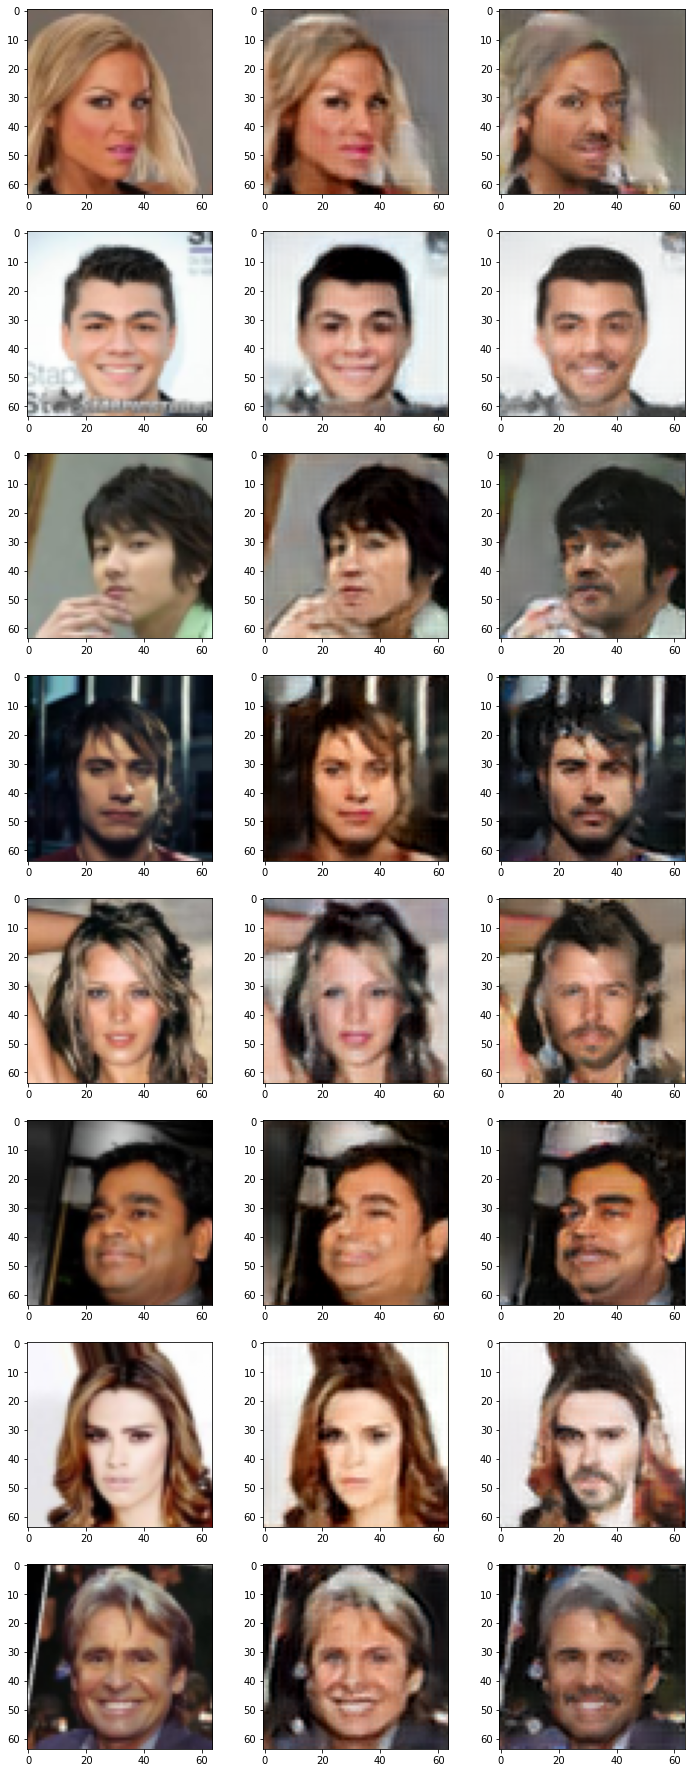

In [ ]:
x_real, d = next(iter(dataloader))
y_org = d['attributes'].to(device)
x_ref, _ = next(iter(dataloader))
x_real, x_ref = x_real.to(device), x_ref.to(device)

batch_size = x_real.shape[0]


fig, axs = plt.subplots(nrows=batch_size // 2, ncols=3, figsize=(12, batch_size * 2))
for j in range(batch_size // 2):
    axs[j][0].imshow((x_real[j].permute(1, 2, 0).detach().cpu().numpy() + 1) / 2)
for i in range(2):
    y_trg = (torch.ones(batch_size) * i).to(device)
    with torch.no_grad():
        s_trg = nets_ema.style_encoder(x_ref, y_trg)
        x_fake = nets_ema.generator(x_real, s_trg)
        for j in range(batch_size // 2):
            axs[j][i + 1].imshow((x_fake[j].permute(1, 2, 0).detach().cpu().numpy() + 1).clip(0, 2) / 2)
plt.savefig('im3.png', pad_inches=0)
plt.show()

# Этап 3(\*). Дополнительный анализ

* Анализ латентного пространства и визуально качественный результат - **2 балла**
* Текстовое ревью решения и предложения возможных улучшений - **1 балл**

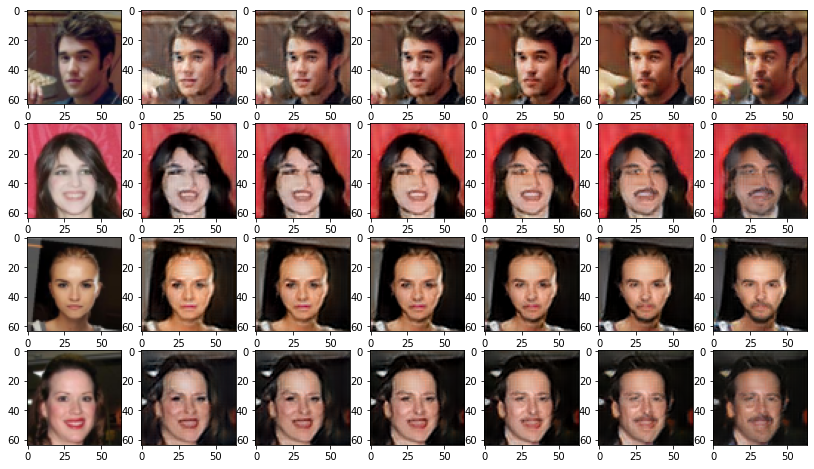

In [ ]:
x_real, d = next(iter(dataloader))
y_org = d['attributes'].to(device)
x_ref, _ = next(iter(dataloader))
x_real, x_ref = x_real.to(device), x_ref.to(device)

batch_size = x_real.shape[0]


fig, axs = plt.subplots(nrows=batch_size // 4, ncols=7, figsize=(14, batch_size // 2))
for j in range(batch_size // 4):
    axs[j][0].imshow((x_real[j].permute(1, 2, 0).detach().cpu().numpy() + 1) / 2)
    
y_trg1 = (torch.ones(batch_size) * 0).to(device)
y_trg2 = (torch.ones(batch_size) * 1).to(device)
with torch.no_grad():
    s_trg1 = nets_ema.style_encoder(x_ref, y_trg1)
    s_trg2 = nets_ema.style_encoder(x_ref, y_trg2)
        
    x_fake = [nets_ema.generator(x_real, lbd * s_trg1 + (1 - lbd) * s_trg2) for lbd in [1, 0.8, 0.6, 0.4, 0.2, 0]]
    for j in range(batch_size // 4):
        for i in range(6):
            axs[j][i + 1].imshow((x_fake[i][j].permute(1, 2, 0).detach().cpu().numpy() + 1).clip(0, 2) / 2)
plt.savefig('latent.png')
plt.show()